In [64]:
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [76]:
def get_data_and_info(fits_path, fits_name):
    #extract data and information about data
    hdul = fits.open(fits_path+fits_name)
    data_uJ = hdul[0].data[0]
    data = data_uJ/1000 #mJ/beam
    hdr = hdul[0].header
    dlt_N_deg = abs(hdr['CDELT1'])
    dlt_n_deg = abs(hdr['CDELT2'])
    N = hdr['NAXIS1']
    n = hdr['NAXIS2']
    nu_data = hdr['CRVAL3']
    nu_BW = hdr['CDELT3']
    HPBW_deg = hdr['BMIN']
    return data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW

def make_coords(N, n, dlt_N, dlt_n, loc='centered'):
    if loc=='centered':
        ax_N_unit = np.linspace(-(N-1)/2, (N-1)/2, N)
        ax_n_unit = np.linspace(-(n-1)/2, (n-1)/2, n)
    elif loc=='edges':
        ax_N_unit = np.linspace(-N/2, N/2, N+1)
        ax_n_unit = np.linspace(-n/2, n/2, n+1)
    return dlt_N*ax_N_unit, dlt_n*ax_n_unit

def find_circular_rings(THETA, th_range):
    ind = np.where(np.logical_or(THETA<th_range[0], THETA>th_range[1]))
    return ind

#puts indices in decending order with respect to a certain axis
def sort_ind(ind, axis=0):
    p = ind[0].argsort()[::-1]
    new_ind = ()
    for elem in ind:
        new_ind += (elem[p],)
    return new_ind

def mask_image(image, ind , sort=True):
    sh = image.shape
    #reshape image if neccessary 
    if not len(sh) == 3:
        n = sh[0]
        N = sh[1]
        block_image = np.transpose(image).reshape(N,n)
    else:
        block_image = image

    #convert block_image to a list of arrays
    block_image_ls = list(block_image)
    
    #sort indices if neccesary
    if sort:
        #reorder ind
        ind = sort_ind(ind)
    
    #remove entries
    for i in range(len(ind[0])):
        block_image_ls[ind[1][i]] = np.delete(block_image_ls[ind[1][i]], ind[0][i], 0)
    
    return block_image_ls
        
def f(x, w):
    elliptic_d = np.sqrt(x[0]**2+w[2]*x[1]**2)
    return w[0]+w[1]*np.exp(-(elliptic_d-w[3])**2/(2*w[4]))

def df_dw(x, w):
    wb = w[0]
    wr = w[1]
    r2 = w[2]
    a = w[3]
    sig_a2 = w[4]
    
    df_dw0 = 1*x[0]
    elliptic_d = np.sqrt(x[0]**2+r2*x[1]**2)
    exponential = np.exp(-(elliptic_d-a)**2/(2*sig_a2))
    df_dw1 = exponential
    df_dw2 = np.where(x[1]==0, 0, -(wr*x[1]**2/(2*sig_a2))*((a/np.sqrt(x[0]**2+r2*x[1]**2))-1)*exponential)
    df_dw3 = wr*((elliptic_d-a)/sig_a2)*exponential
    df_dw4 = wr*((elliptic_d-a)**2/(2*sig_a2**2))*exponential
    return np.vstack(tuple((df_dw0, df_dw1, df_dw2, df_dw3, df_dw4)))

def d2f_dw2(x, w):
    wb = w[0]
    wr = w[1]
    r2 = w[2]
    a = w[3]
    sig_a2 = w[4]
    
    #useful quantities
    elliptic_d = np.sqrt(x[0]**2+r2*x[1]**2)
    exponential = np.exp(-(elliptic_d-a)**2/(2*sig_a2))
    
    #compute elements of the symmetric 5x5 matrix
    dw0dw0 = 0*x[0]
    dw0dw1 = 0*x[0]
    dw0dw2 = 0*x[0]
    dw0dw3 = 0*x[0]
    dw0dw4 = 0*x[0]
    
    dw1dw1 = 0*x[0]
    dw1dw2 = np.where(x[1]==0, 0, -(x[1]**2/(2*sig_a2))*((a/np.sqrt(x[0]**2+r2*x[1]**2))-1)*exponential)
    dw1dw3 = ((elliptic_d-a)/sig_a2)*exponential
    dw1dw4 = ((elliptic_d-a)**2/(2*sig_a2**2))*exponential
    
    dw2dw2 = np.where(x[1]==0, 0, wr*((x[1]**4/(4*sig_a2**2))*((a/elliptic_d)-1)**2-(a*x[1]**4/(4*sig_a2*elliptic_d**3)))*exponential)
    dw2dw3 = np.where(x[1]==0, 0, (wr*x[1]**2/(2*sig_a2))*((a/elliptic_d-1)*(elliptic_d-a/sig_a2)+1/elliptic_d)*exponential)
    dw2dw4 = np.where(x[1]==0, 0, (wr*x[1]**2/(2*sig_a2**2))*(a/elliptic_d-1)*((elliptic_d-a)/(2*sig_a2)-1)*exponential)
    
    dw3dw3 = wr*(((elliptic_d-a)/sig_a2)**2-1/sig_a2)*exponential
    dw3dw4 = wr*((elliptic_d-a)/sig_a2**2)*((elliptic_d-a)**2/(2*sig_a2)-1)*exponential
    
    dw4dw4 = wr*((elliptic_d-a)**2/sig_a2**3)*((elliptic_d-a)**2/(4*sig_a2)-1)*exponential
    
    res = np.array([[dw0dw0, dw0dw1, dw0dw2, dw0dw3, dw0dw4], \
                    [dw0dw1, dw1dw1, dw1dw2, dw1dw3, dw1dw4], \
                    [dw0dw2, dw1dw2, dw2dw2, dw2dw3, dw2dw4], \
                    [dw0dw3, dw1dw3, dw2dw3, dw3dw3, dw3dw4], \
                    [dw0dw4, dw1dw4, dw2dw4, dw3dw4, dw4dw4]])
    return res
    
def im_to_1d(image, kind='list'):
    if kind=='list':
        image_t = tuple(image)
    res = np.hstack(image_t)
    return res

#args = (data, x, sigma)
def chi2(w, *args):
    model = f(args[1], w)
    return np.sum((args[0]-model)**2/args[2]**2)

#args = (data, x, sigma)
def dchi_dw(w, *args):
    model = f(args[1], w)
    res = -2*np.sum(((args[0]-model)/args[2]**2)*df_dw(args[1], w), axis=1)
    return res

def d2chi_dw2(data, x, w, sigma):
    num_params = len(w)
    model = f(x, w)
    dfdw_arr = df_dw(x, w)
    dfdw2 = np.array([[dfdw_arr[i]*dfdw_arr[j] for i in range(num_params)] for j in range(num_params)])
    before_sum = 2*(dfdw2/sigma**2-((data-model)/sigma**2)*d2f_dw2(x, w))
    return np.sum(before_sum, axis=2)

def update_w(w_init, data, x, sigma, eta=1):
    num_params = len(w_init)
    grad_chi = dchi_dw(data, x, w_init, sigma)
    print('grad = ', grad_chi)
    grad_chi_v = grad_chi.reshape(num_params, 1)
    d2chidw2 = d2chi_dw2(data, x, w_init, sigma)
    print('2nd deriv = ', d2chidw2)
    inv_d2chidw2 = np.linalg.inv(d2chidw2)
    print('inv = ', inv_d2chidw2)
    dw_v = - np.matmul(inv_d2chidw2, grad_chi)
    dw =dw_v.reshape(num_params)
    dot_prod = -np.sum(dw*grad_chi)
    print(dot_prod)
    if dot_prod<=0:
        mag_grad = np.sqrt(np.sum(grad_chi**2))
        mag_dw = np.sqrt(np.sum(dw**2))
        w_fin = w_init - eta*(mag_dw/mag_grad)*grad_chi
    else:
        w_fin = w_init - dw
    
    return w_fin

In [66]:
#define relevant paths and names
base_path = os.getcwd().split('scripts')[0]
fits_path = base_path.split('Secondary_radiation')[0] + 'synchrotron_data/'
fits_name = 'm31cm3nthnew.ss.90sec.fits'

In [67]:
#extract info about data
data, dlt_N_deg, dlt_n_deg, N, n, HPBW_deg, nu_data, nu_BW = get_data_and_info(fits_path, fits_name)
dlt_N = dlt_N_deg*np.pi/180
dlt_n = dlt_n_deg*np.pi/180
HPBW = HPBW_deg*np.pi/180
sigma_BW = HPBW/(2*np.sqrt(2*np.log(2)))
omega_beam = 2*np.pi*sigma_BW**2
sigma = .25
print('real data info extracted')

real data info extracted


In [68]:
#create coords for data
ax_N, ax_n = make_coords(N, n, dlt_N, dlt_n)
AX_N, AX_n = np.meshgrid(ax_N, ax_n)
THETA = np.sqrt(AX_N**2+AX_n**2)

In [242]:
#make a guess for model params
wb = 4.64038904e-01
wr = .05
r2 = 3.9**2
a = 0.013
sigma_a2 = .003**2
w_init = np.array([wb, wr, r2, a, sigma_a2])
model = f([AX_N, AX_n], w_init)

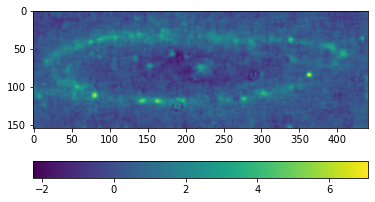

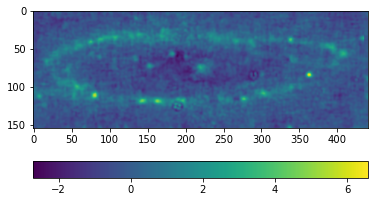

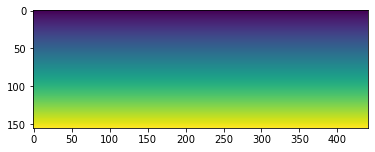

In [243]:
plt.imshow(data)
plt.colorbar(orientation="horizontal")
fig = plt.figure()
plt.imshow(data-model)
plt.colorbar(orientation="horizontal")
fig = plt.figure()
plt.imshow(AX_n)

In [244]:
#mask center coords and turn 2d arrays into lists of 1d arrays
th_range = [0.0015, np.pi]
ind = find_circular_rings(THETA, th_range)
ind = sort_ind(ind)
data_ma = mask_image(data, ind, sort=False)
model_ma = mask_image(model, ind, sort=False)
THETA_ma = mask_image(THETA, ind, sort=False)
AXN_ma = mask_image(AX_N, ind, sort=False)
AXn_ma = mask_image(AX_n, ind, sort=False)

In [245]:
#convert images and coords to 1d array
data_ar = im_to_1d(data_ma)
model_ar = im_to_1d(model_ma)
THETA_ar = im_to_1d(THETA_ma)
AXN_ar = im_to_1d(AXN_ma)
AXn_ar = im_to_1d(AXN_ma)
x = [AXN_ar, AXn_ar] 
w_all = []
chi_all = []

In [106]:
#NOT CORRECT. FUNCTIONS HAVE BEEN CHANGED

this_chi2 = chi2(data_ar, x, w_init, sigma)
statement1 = 'initial weights are: '
for j in range(len(w_init)):
    statement1 += 'w' + str(j) + ' = ' + str(w_init[j]) + '; '
print(statement1)
print('chi^2 = ' + str(this_chi2))
# update weights
num_epochs = 10
w_all.append(w_init)
chi_all.append(this_chi2)
for i in range(num_epochs):
    w_new = update_w(w_init, data_ar, x, sigma)
    statement1 = 'epoch ' + str(i+1) + ' weights are: '
    for j in range(len(w_new)):
        statement1 += 'w' + str(j) + ' = ' + str(w_new[j]) + '; '
    print(statement1)
    w_all.append(w_new)
    
    this_chi2 = chi2(data_ar, x, w_new, sigma)
    print('epoch ' + str(i+1) + ' chi^2 = ' + str(this_chi2))
    chi_all.append(this_chi2)
    

initial weights are: w0 = 0.0; w1 = 1.5; w2 = 15.209999999999999; w3 = 0.0148; w4 = 9e-06; 
chi^2 = nan


/cms/base/HETconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in sqrt
/cms/base/HETconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in sqrt
/cms/base/HETconda/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in sqrt


ValueError: operands could not be broadcast together with shapes (2,67002) (5,1) 

In [246]:
this_chi2 = chi2(w_init, *(data_ar, x,  sigma))
statement1 = 'initial weights are: '
for j in range(len(w_init)):
    statement1 += 'w' + str(j) + ' = ' + str(w_init[j]) + '; '
print(statement1)
print('chi^2 = ' + str(this_chi2))
# update weights
bnds = [(-1, 1), (0, 1), (9, 25), (.005 ,0.03), (1e-6, 1e-5)]
cons = ({'type': 'eq', 'fun': lambda w:  w[1] - .5},

        {'type': 'eq', 'fun': lambda w: w[4] - 9e-6})

res = minimize(chi2, w_init, args=(data_ar, x, sigma), bounds=bnds)

initial weights are: w0 = 0.464038904; w1 = 0.05; w2 = 15.209999999999999; w3 = 0.013; w4 = 9e-06; 
chi^2 = 565082.6183169356


[4.63238382e-01 4.98483173e-02 1.52064219e+01 1.59501399e-02
 1.00000000e-06]
True
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
final: 564284.9566994705


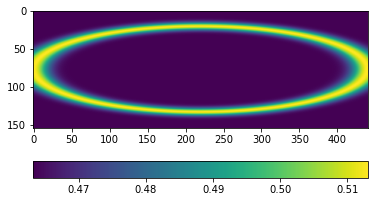

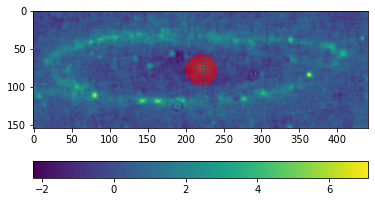

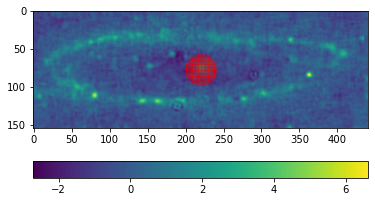

In [247]:
w_fin = res.x
print(w_fin)
print(res.success)
print(res.message)
chi2_final = chi2(w_fin, *(data_ar, x, sigma))
print('final: '+ str(chi2_final)) 
fig = plt.figure()
new_model = f([AX_N, AX_n], w_fin)
plt.imshow(new_model) 
plt.colorbar(orientation='horizontal')
fig = plt.figure()
plt.imshow(data)
plt.colorbar(orientation='horizontal')
plt.scatter(ind[1], ind[0], s=1/64, color='r')
fig = plt.figure()
plt.imshow(data-new_model)
plt.colorbar(orientation='horizontal')
plt.scatter(ind[1], ind[0], s=1/64, color='r')

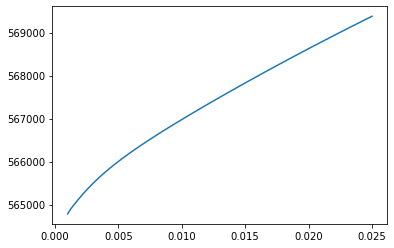

In [239]:
num_pts = 500
w1 = np.linspace(0, 2, num_pts)
w2 = np.linspace(9, 25, num_pts)
w3 = np.linspace(.001, .025, num_pts)
w4 = np.linspace(1e-7, 1e-5, num_pts)
chi2_w = np.array([chi2([w_fin[0], w_fin[1], w_fin[2], w_fin[3], w4[i]], *(data_ar, x, sigma)) for i in range(num_pts)])
plt.plot(w3, chi2_w)

w_fin = res.x
print(w_fin)
print(res.success)
print(res.message)
chi2_final = chi2(w_fin, *(data_ar, x,  sigma))
print('final: '+ str(chi2_final))
fig = plt.figure()
plt.imshow(f([AX_N, AX_n], w_fin))
plt.colorbar()
fig = plt.figure()
plt.imshow(data)
#plt.colorbar()
plt.scatter(ind[1], ind[0], s=1/64, color='r')